In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from tomopt.core import *
from tomopt.volume import *
from tomopt.inference import *
from tomopt.muon import *
from tomopt.optimisation import *

In [3]:
DEVICE = torch.device('cpu')

<ipython-input-4-5787166f89b9>:4: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  ../aten/src/ATen/native/RangeFactories.cpp:23.)
  x = torch.linspace(-1, 1)


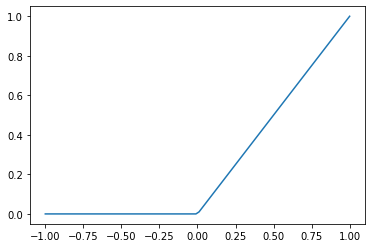

In [4]:
def area_cost(x:Tensor) -> Tensor:
    return F.relu(x)

x = torch.linspace(-1, 1)
plt.plot(x, area_cost(x))

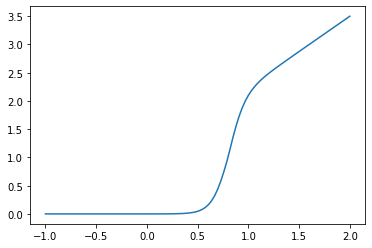

In [5]:
def area_coef(x:Tensor, targ:float) -> Tensor:
    return (2*torch.sigmoid(10*(x-targ)/targ)) + F.relu(x-targ)/targ

x = torch.linspace(-1, 2)
plt.plot(x, area_coef(x, 0.8))

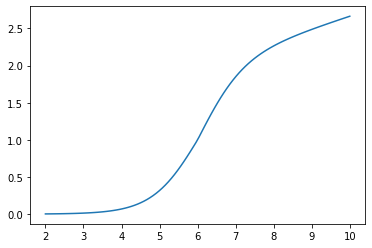

In [6]:
def area_coef(x:Tensor, targ:float) -> Tensor:
    return (2*torch.sigmoid(10*(x-targ)/targ)) + F.relu(x-targ)/targ

x = torch.linspace(2, 10)
plt.plot(x, area_coef(x, 6))

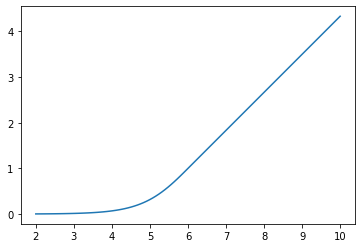

In [7]:
def area_coef(x:Tensor, targ:float) -> Tensor:
    d = 10*(x - targ)/targ
    m = d > 0
    c = 2*torch.sigmoid(d)
    c[m] = 1+(d[m]/2)
    return c

x = torch.linspace(2, 10)
plt.plot(x, area_coef(x, 6))

In [31]:
from typing import *

class DetectorLoss(nn.Module):
    def __init__(self, target_budget: Optional[Union[Tensor, float]]=None, budget_smoothing:Union[Tensor, float]=10):
        super().__init__()
        self.target_budget, self.budget_smoothing = target_budget, budget_smoothing
        self.sub_losses: Dict[str, Tensor] = {}  # Store subcomponents in dict for telemetry
            
    def _get_budget_coef(self, cost: Tensor) -> Union[Tensor, float]:
        r'''Switch-on near target budget, plus linear increase above budget'''
        if self.target_budget is None: return 0
        d = self.budget_smoothing*(cost-self.target_budget)/self.target_budget
        if d <= 0:
            return 2*torch.sigmoid(d)
        else:
            return 1+(d/2)

    def forward(self, pred_x0: Tensor, pred_weight: Tensor, volume: Volume) -> Tensor:
        true_x0 = volume.get_rad_cube()
        inference = torch.mean((pred_x0 - true_x0).pow(2) / pred_weight)
        self.sub_losses["error"] = inference
        cost = volume.get_cost()
        self.sub_losses["cost"] = self._get_budget_coef(cost) * self.sub_losses["error"]
        print(f'Loss details: cost {cost:.3E}, budget coef {self._get_budget_coef(cost):.3E}. error loss {self.sub_losses["error"]:.3E}, cost loss {self.sub_losses["cost"]:.3E}')
        return self.sub_losses["error"] + self.sub_losses["cost"]

In [9]:
from typing import *

class DetectorLoss(nn.Module):
    def __init__(
        self,
        *,
        target_budget: float,
        budget_smoothing: float = 10,
        cost_coef: Optional[Union[Tensor, float]] = None,
        debug: bool = False,
    ):
        super().__init__()
        self.target_budget, self.budget_smoothing, self.cost_coef, self.debug = target_budget, budget_smoothing, cost_coef, debug
        self.sub_losses: Dict[str, Tensor] = {}  # Store subcomponents in dict for telemetry
            
    def _get_budget_coef(self, cost: Tensor) -> Union[Tensor, float]:
        r'''Switch-on near target budget, plus linear increase above budget'''
        if self.target_budget is None: return 0
        d = self.budget_smoothing*(cost-self.target_budget)/self.target_budget
        if d <= 0:
            return 2*torch.sigmoid(d)
        else:
            return 1+(d/2)
        
#     def _get_budget_coef(self, cost: Tensor) -> Union[float, Tensor]:
#         r"""Switch-on near target budget, plus linear increase above budget"""
#         if self.target_budget == 0:
#             return 0
#         d = cost - self.target_budget
#         return (2 * torch.sigmoid(self.budget_smoothing * d / self.target_budget)) + (F.relu(d) / self.target_budget)

    def _compute_cost_coef(self, cost: Tensor, inference: Tensor) -> None:
        self.cost_coef = inference.detach().clone() / cost.detach()
        print(f"Automatically setting cost coefficient to {self.cost_coef}")

    def forward(self, pred_x0: Tensor, pred_weight: Tensor, volume: Volume) -> Tensor:
        self.sub_losses = {}
        true_x0 = volume.get_rad_cube()
        inference = torch.mean((pred_x0 - true_x0).pow(2) / pred_weight)
        self.sub_losses["error"] = inference
        cost = volume.get_cost()
        if self.cost_coef is None:
            self._compute_cost_coef(cost, inference)
        self.sub_losses["cost"] = self._get_budget_coef(cost) * self.cost_coef * cost
        if self.debug:
            print(
                f'cost {cost}, cost coef {self.cost_coef}, budget coef {self._get_budget_coef(cost)}. error loss {self.sub_losses["error"]}, cost loss {self.sub_losses["cost"]}'
            )
        return self.sub_losses["error"] + self.sub_losses["cost"]

In [35]:
from typing import *

class DetectorLoss(nn.Module):
    def __init__(
        self,
        *,
        target_budget: float,
        budget_smoothing: float = 10,
        cost_coef: Optional[Union[Tensor, float]] = None,
        debug: bool = False,
    ):
        super().__init__()
        self.target_budget, self.budget_smoothing, self.cost_coef, self.debug = target_budget, budget_smoothing, cost_coef, debug
        self.sub_losses: Dict[str, Tensor] = {}  # Store subcomponents in dict for telemetry
            
    def _get_budget_coef(self, cost: Tensor) -> Union[float, Tensor]:
        r"""Switch-on near target budget, plus linear increase above budget"""
        if self.target_budget == 0:
            return 0
        d = cost - self.target_budget
        return (2 * torch.sigmoid(self.budget_smoothing * d / self.target_budget)) + (F.relu(d) / self.target_budget)

    def _compute_cost_coef(self, cost: Tensor, inference: Tensor) -> None:
        self.cost_coef = inference.detach() / cost.detach()
        print(f"Automatically setting cost coefficient to {self.cost_coef}")

    def forward(self, pred_x0: Tensor, pred_weight: Tensor, volume: Volume) -> Tensor:
        self.sub_losses = {}
        true_x0 = volume.get_rad_cube()
        inference = torch.mean((pred_x0 - true_x0).pow(2) / pred_weight)
        self.sub_losses["error"] = inference
        cost = volume.get_cost()
        if self.cost_coef is None:
            self._compute_cost_coef(cost, inference)
        self.sub_losses["cost"] = self._get_budget_coef(cost) * self.cost_coef * cost
        if self.debug:
            print(
                f'cost {cost}, cost coef {self.cost_coef}, budget coef {self._get_budget_coef(cost)}. error loss {self.sub_losses["error"]}, cost loss {self.sub_losses["cost"]}'
            )
        return self.sub_losses["error"] + self.sub_losses["cost"]

In [32]:
def get_layers():
    layers = []
    lwh = Tensor([1,1,1])
    size = 0.1
    init_eff = 0.5
    init_res = 1000
    n_panels = 4
    layers.append(PanelDetectorLayer(pos='above', lw=lwh[:2], z=1, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,1-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))
    for z in [0.8,0.7,0.6,0.5,0.4,0.3]:
        layers.append(PassiveLayer(lw=lwh[:2], z=z, size=size, device=DEVICE))
    layers.append(PanelDetectorLayer(pos='below', lw=lwh[:2], z=0.2, size=2*size,
                                     panels=[DetectorPanel(res=init_res, eff=init_eff,
                                                      init_xyz=[0.5,0.5,0.2-(i*(2*size)/n_panels)], init_xy_span=[1.0,1.0],
                                                      area_cost_func=area_cost, device=DEVICE) for i in range(n_panels)]))

    return nn.ModuleList(layers) 

In [33]:
volume = Volume(get_layers())
volume

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.]), and xy span tensor([1., 1.])
        (1): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9500]), and xy span tensor([1., 1.])
        (2): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.9000]), and xy span tensor([1., 1.])
        (3): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.8500]), and xy span tensor([1., 1.])
      )
    )
    (1): PassiveLayer()
    (2): PassiveLayer()
    (3): PassiveLayer()
    (4): PassiveLayer()
    (5): PassiveLayer()
    (6): PassiveLayer()
    (7): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.DetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([0.2000]),

In [25]:
volume.get_cost()

tensor(8., grad_fn=<AddBackward0>)

In [26]:
from tomopt.optimisation.callbacks.callback import Callback

class CostCoefAdapter(Callback):
    def __init__(self, mom:Union[float,Tensor]):
        self.mom = mom
        
    def on_epoch_begin(self) -> None:
        self.sum: Optional[Tensor] = None
        self.volume_cnt = 0
            
    def on_volume_end(self) -> None:
        if self.wrapper.fit_params.state == 'train' and self.wrapper.fit_params.pred is not None:
            v = self.wrapper.loss_func.sub_losses['error'].detach()/self.wrapper.volume.get_cost().detach()
            if self.sum is None:
                self.sum = v
            else:
                self.sum += v
            self.volume_cnt += 1
            
    def on_epoch_end(self) -> None:
        if self.wrapper.fit_params.state == 'train':
            avg = self.sum/self.volume_cnt
            if self.wrapper.loss_func.cost_coef is None: self.wrapper.loss_func.cost_coef = avg
            else: self.wrapper.loss_func.cost_coef.lerp_(avg, self.mom)

In [35]:
wrapper = PanelVolumeWrapper(volume,
                             xy_pos_opt=partial(torch.optim.SGD, lr=1e2),
                             z_pos_opt=partial(torch.optim.SGD, lr=5e3),
                             xy_span_opt=partial(torch.optim.SGD, lr=1e5),
                             loss_func=DetectorLoss(target_budget=0.8))  # Loss is precision + cost_coef*detector cost, balance coef as required or leave as None to automatically balance on first batch

In [36]:
def arb_rad_length(*,z:float, lw:Tensor, size:float) -> float:
    rad_length = torch.ones(list((lw/size).long()))*X0['beryllium']
    if z >= 0.4 and z <= 0.5: rad_length[5:,5:] = X0['lead']
    return rad_length

In [37]:
passives = PassiveYielder([arb_rad_length])

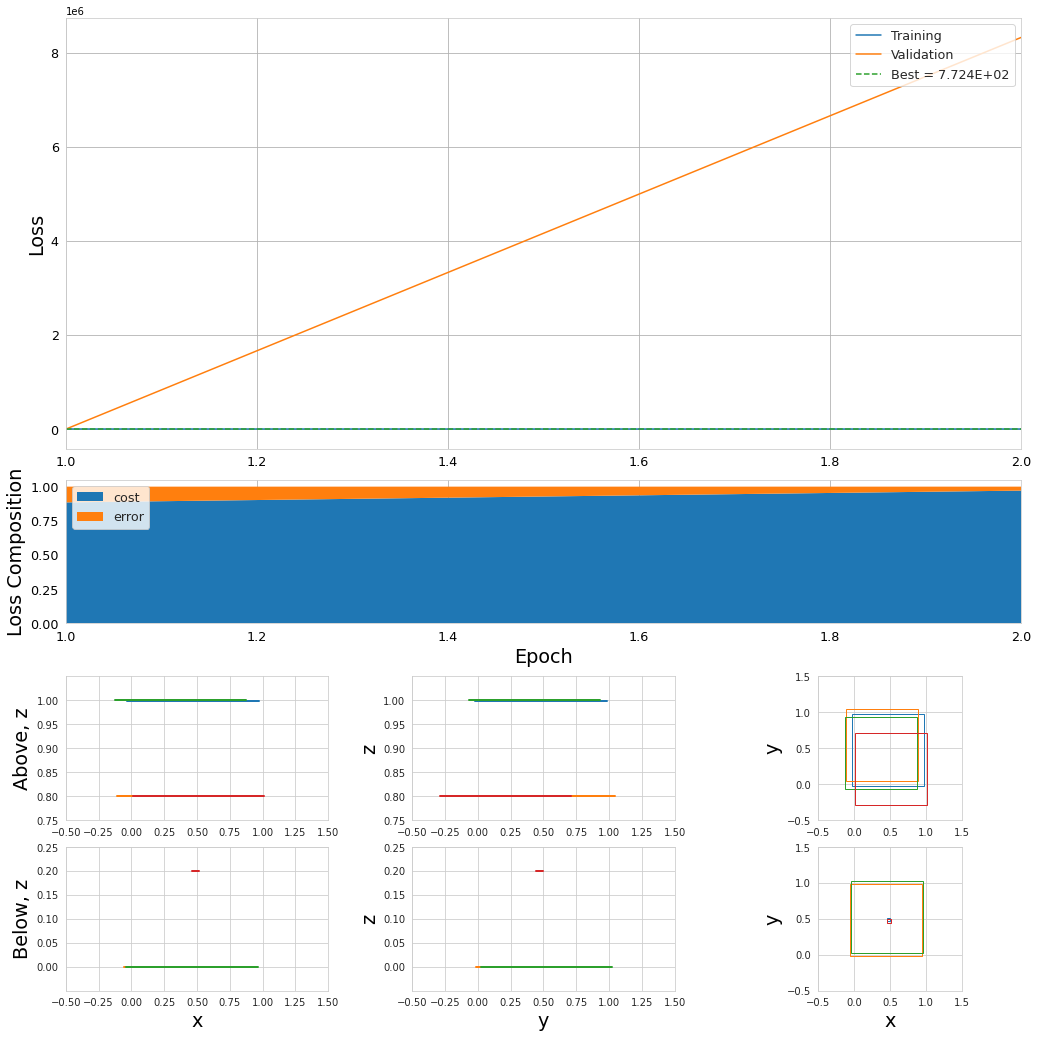

Loss details: cost 8.000E+00, budget coef 4.600E+01. error loss 2.139E-06, cost loss 9.838E-05
Loss details: cost 1.870E+00, budget coef 7.688E+00. error loss 8.890E+01, cost loss 6.835E+02


/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:207: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


Loss details: cost 1.870E+00, budget coef 7.688E+00. error loss 1.845E-04, cost loss 1.418E-03
Loss details: cost 6.005E+00, budget coef 3.353E+01. error loss 2.411E+05, cost loss 8.086E+06
Loss details: cost 6.005E+00, budget coef 3.353E+01. error loss 1.307E+01, cost loss 4.381E+02


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

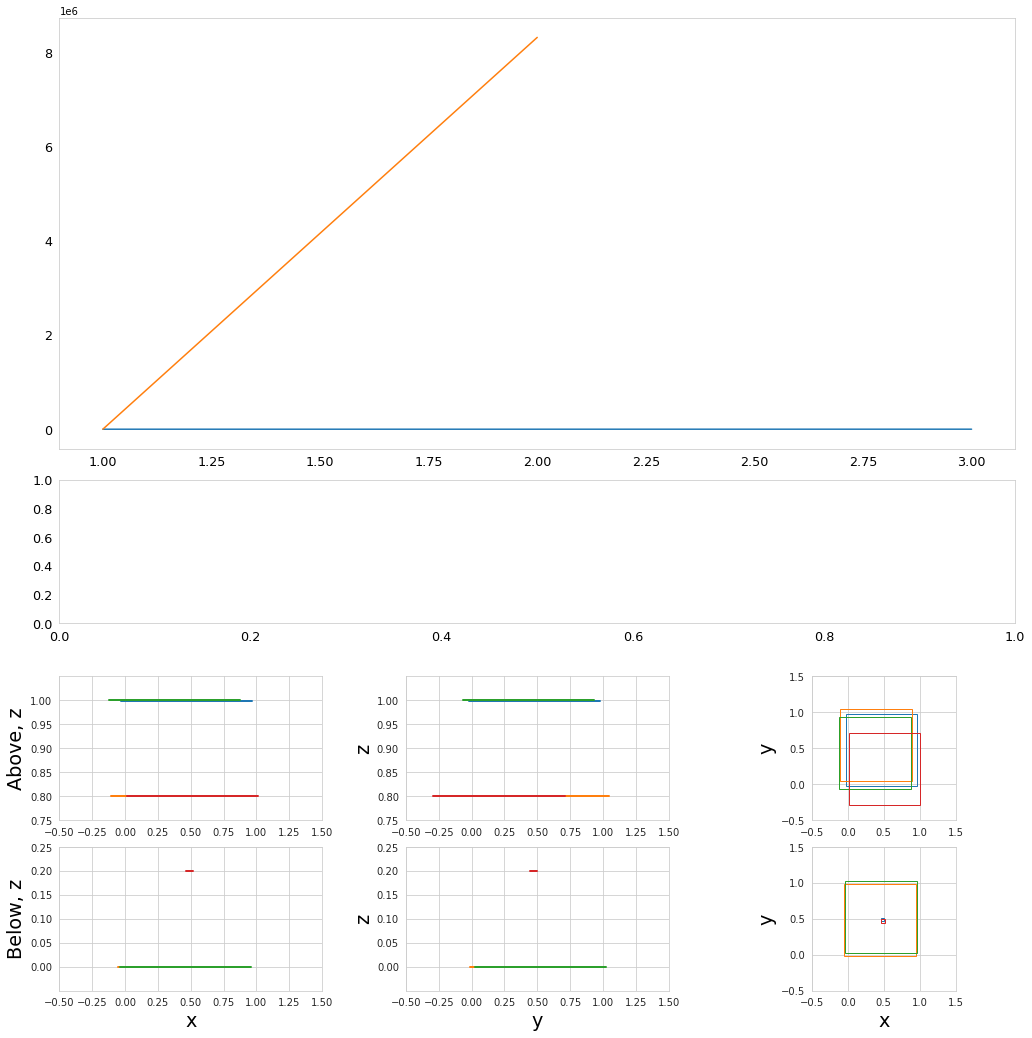

In [38]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[PanelMetricLogger()])

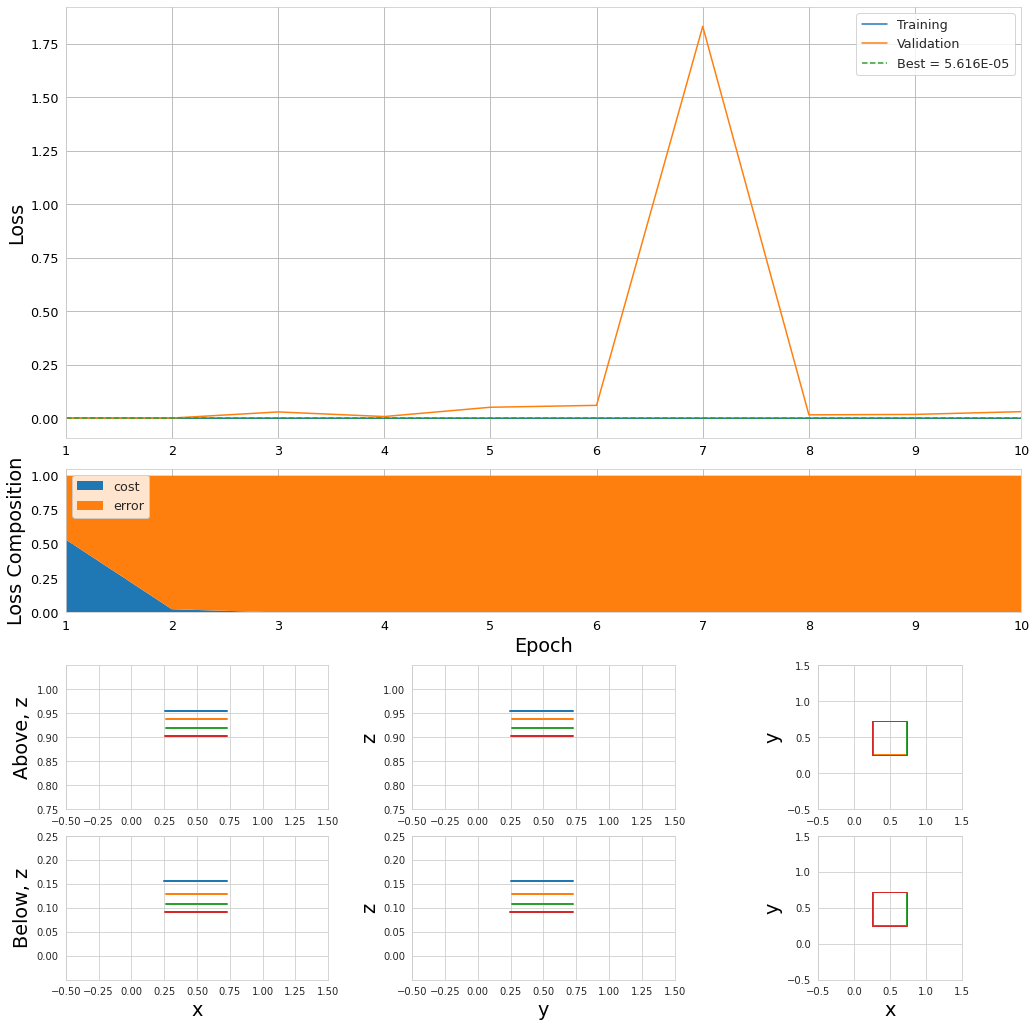

Automatically setting cost coefficient to 1.8157075487579277e-07
cost 8.0, cost coef 1.8157075487579277e-07, budget coef 46.0. error loss 1.4525660390063422e-06, cost loss 6.681803643004969e-05
cost 5.466977596282959, cost coef 1.8157075487579277e-07, budget coef 30.168607711791992. error loss 2.6217850972898304e-05, cost loss 2.9946664653834887e-05


/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:207: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


cost 5.466977596282959, cost coef 1.8157075487579277e-07, budget coef 30.168607711791992. error loss 5.190124738874147e-07, cost loss 2.9946664653834887e-05
cost 4.274025917053223, cost coef 1.7290726361807174e-07, budget coef 22.712663650512695. error loss 0.0006911412929184735, cost loss 1.678488843026571e-05
cost 4.274025917053223, cost coef 1.7290726361807174e-07, budget coef 22.712663650512695. error loss 4.909860535917687e-07, cost loss 1.678488843026571e-05
cost 3.587390184402466, cost coef 1.6710420425170014e-07, budget coef 18.421188354492188. error loss 0.02929837629199028, cost loss 1.104291277442826e-05
cost 3.587390184402466, cost coef 1.6710420425170014e-07, budget coef 18.421188354492188. error loss 7.321246471292397e-07, cost loss 1.104291277442826e-05
cost 3.1388373374938965, cost coef 1.7080206760056171e-07, budget coef 15.6177339553833. error loss 0.007837864570319653, cost loss 8.372977390536107e-06
cost 3.1388373374938965, cost coef 1.7080206760056171e-07, budget c

<Figure size 1024x1024 with 0 Axes>

In [25]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[CostCoefAdapter(0.05), PanelMetricLogger()])

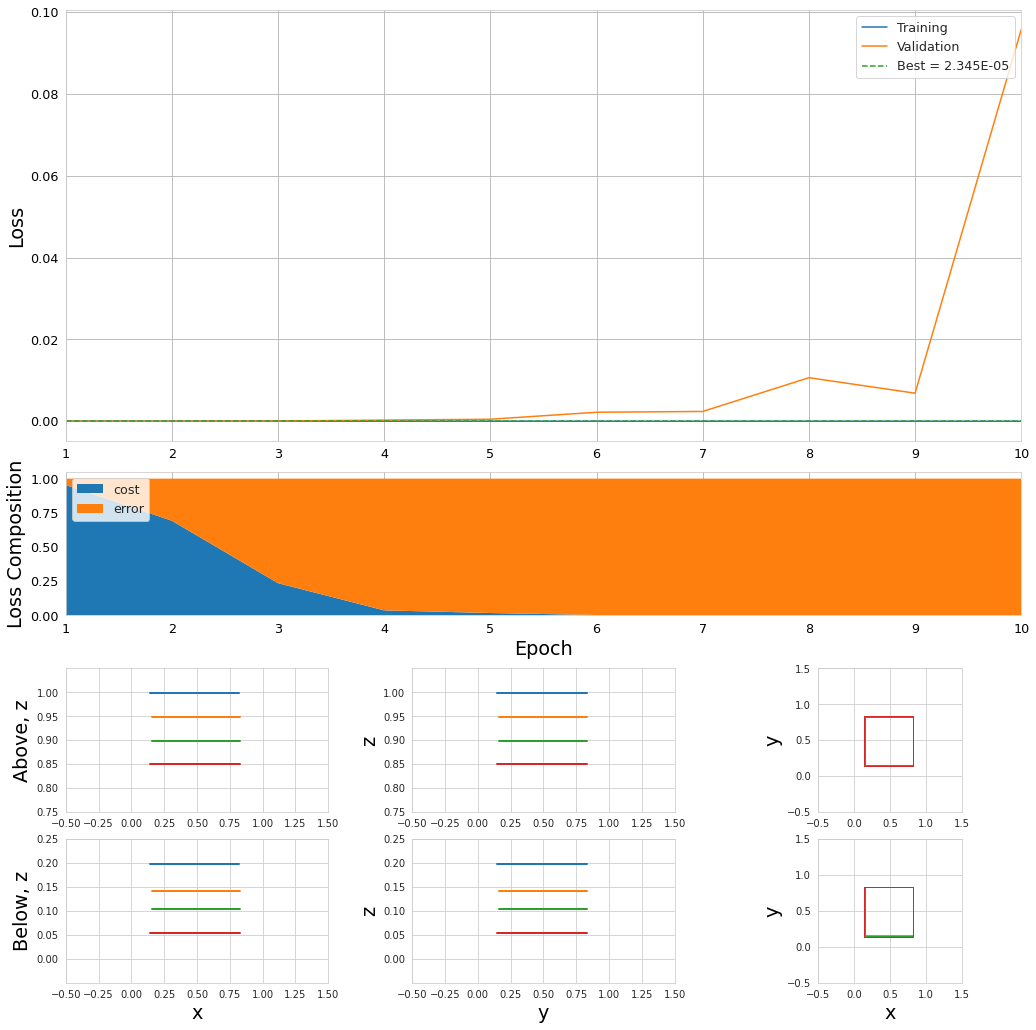

Automatically setting cost coefficient to 3.287240417648718e-07
cost 8.0, cost coef 3.287240417648718e-07, budget coef 11.0. error loss 2.6297923341189744e-06, cost loss 2.8927715902682394e-05
cost 6.986385345458984, cost coef 3.287240417648718e-07, budget coef 9.732980728149414. error loss 1.0977540796375251e-06, cost loss 2.235269312222954e-05


/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:207: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


cost 6.986385345458984, cost coef 3.287240417648718e-07, budget coef 9.732980728149414. error loss 6.80977620959311e-07, cost loss 2.235269312222954e-05
cost 6.173081398010254, cost coef 3.0559885999537073e-07, budget coef 8.716351509094238. error loss 7.3050255195994396e-06, cost loss 1.6443280401290394e-05
cost 6.173081398010254, cost coef 3.0559885999537073e-07, budget coef 8.716351509094238. error loss 6.774781127205642e-07, cost loss 1.6443280401290394e-05
cost 5.5793561935424805, cost coef 2.8601368740055477e-07, budget coef 7.9741950035095215. error loss 4.120743687963113e-05, cost loss 1.2724999578495044e-05
cost 5.5793561935424805, cost coef 2.8601368740055477e-07, budget coef 7.9741950035095215. error loss 9.488682053415687e-07, cost loss 1.2724999578495044e-05
cost 5.126094818115234, cost coef 2.744190794601309e-07, budget coef 7.407618045806885. error loss 0.0002688839449547231, cost loss 1.0420283615530934e-05
cost 5.126094818115234, cost coef 2.744190794601309e-07, budget

<Figure size 1024x1024 with 0 Axes>

In [16]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[CostCoefAdapter(0.1), PanelMetricLogger()])

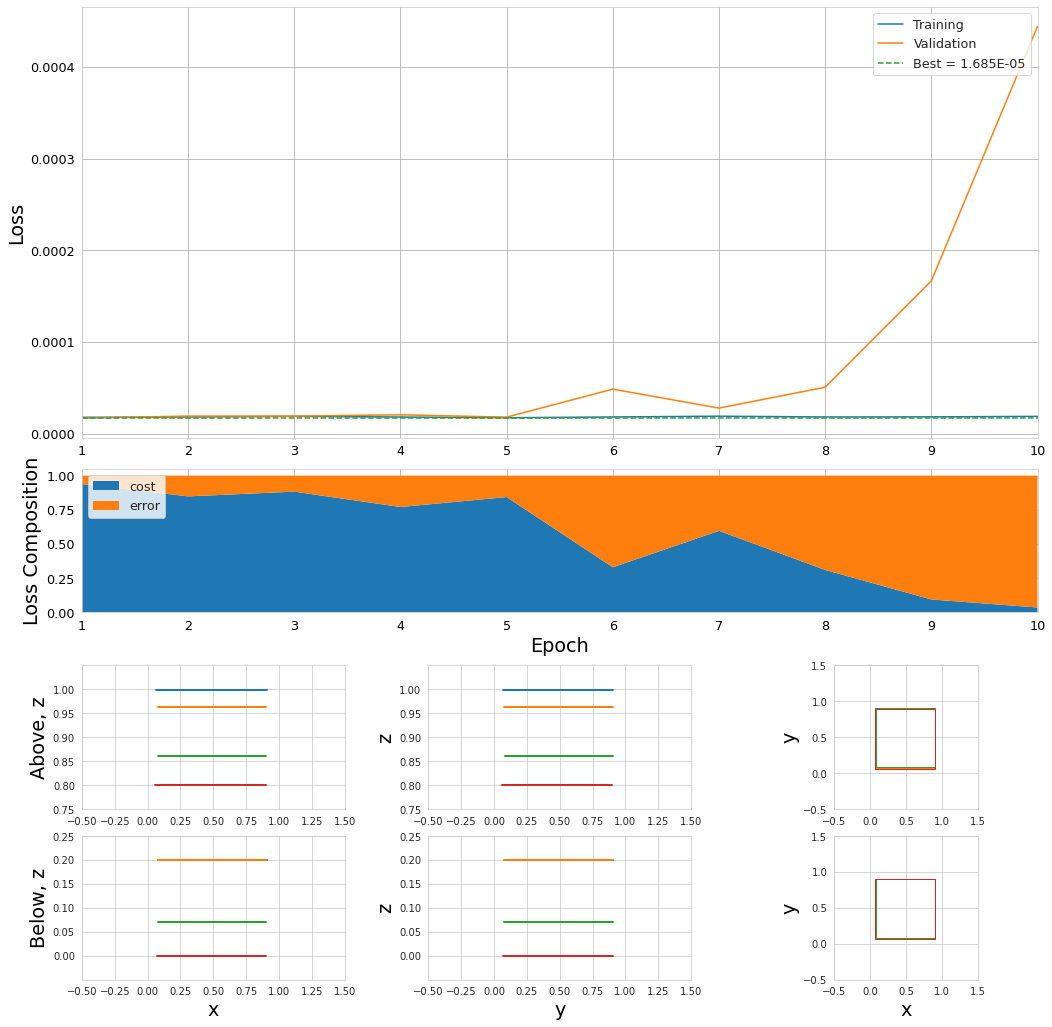

Automatically setting cost coefficient to 1.484530912421178e-06
cost 8.0, cost coef 1.484530912421178e-06, budget coef 11.0. error loss 1.484530912421178e-06, cost loss 1.6329839127138257e-05
cost 7.723687171936035, cost coef 1.484530912421178e-06, budget coef 10.654608726501465. error loss 1.0331417570341728e-06, cost loss 1.5817095118109137e-05


/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:207: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


cost 7.723687171936035, cost coef 1.484530912421178e-06, budget coef 10.654608726501465. error loss 2.3849631816119654e-06, cost loss 1.5817095118109137e-05
cost 7.475176811218262, cost coef 1.574574184814992e-06, budget coef 10.34397029876709. error loss 2.9118216389178997e-06, cost loss 1.628734935366083e-05
cost 7.475176811218262, cost coef 1.574574184814992e-06, budget coef 10.34397029876709. error loss 2.6575312404020224e-06, cost loss 1.628734935366083e-05
cost 7.219715118408203, cost coef 1.6828698790050112e-06, budget coef 10.024643898010254. error loss 2.234643034171313e-06, cost loss 1.6870171748450957e-05
cost 7.219715118408203, cost coef 1.6828698790050112e-06, budget coef 10.024643898010254. error loss 1.256951009054319e-06, cost loss 1.6870171748450957e-05
cost 6.93622350692749, cost coef 1.6402780147473095e-06, budget coef 9.670278549194336. error loss 4.714561328000855e-06, cost loss 1.5861945939832367e-05
cost 6.93622350692749, cost coef 1.6402780147473095e-06, budget 

<Figure size 1024x1024 with 0 Axes>

In [91]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[CostCoefAdapter(0.1), PanelMetricLogger()])

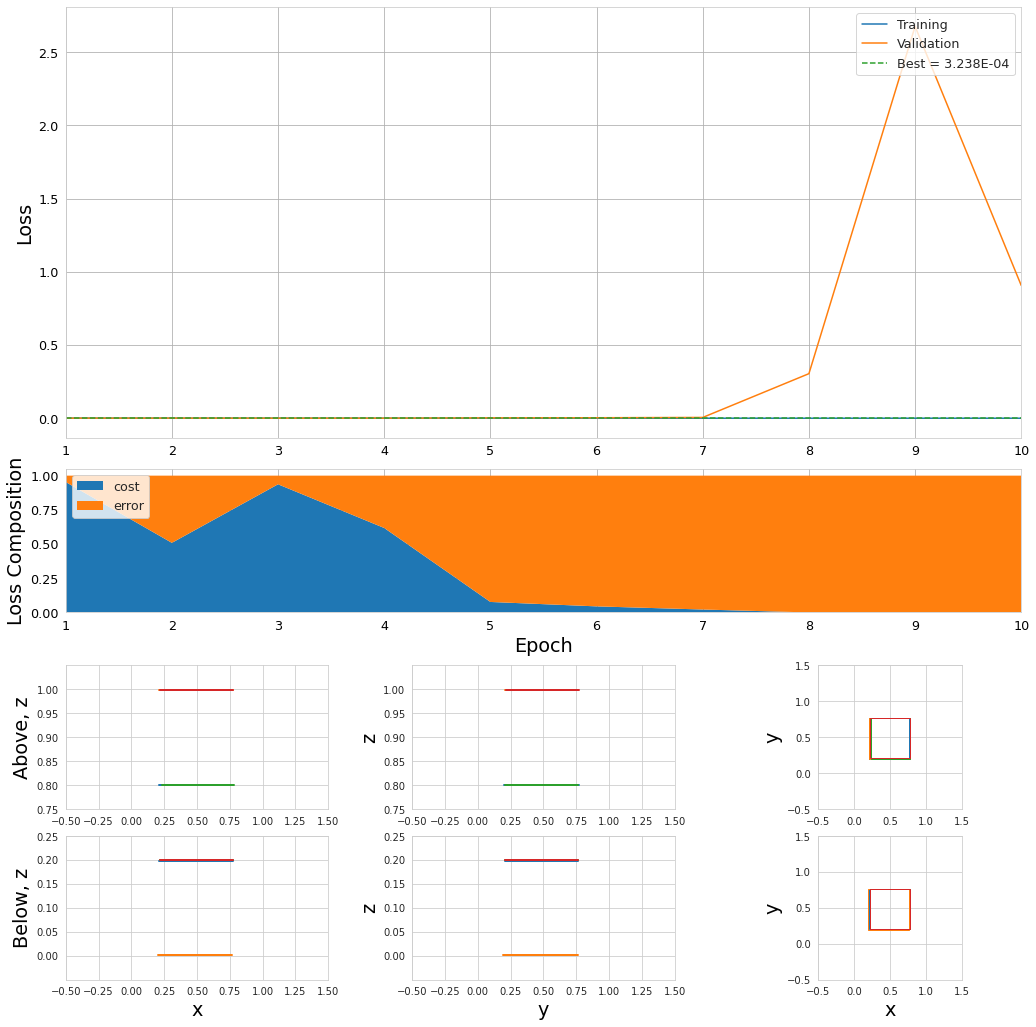

Automatically setting cost coefficient to 1.1826399713754654e-05
cost 8.0, cost coef 1.1826399713754654e-05, budget coef 46.0. error loss 1.1826399713754654e-05, cost loss 0.0005440143868327141
cost 6.874896049499512, cost coef 1.1826399713754654e-05, budget coef 38.96809768676758. error loss 2.249689532618504e-05, cost loss 0.0004608522867783904


/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:207: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


cost 6.874896049499512, cost coef 1.1826399713754654e-05, budget coef 38.96809768676758. error loss 1.0913304322457407e-05, cost loss 0.0004608522867783904
cost 5.912609100341797, cost coef 1.1735090083675459e-05, budget coef 32.95380401611328. error loss 0.00037323147989809513, cost loss 0.000386715866625309
cost 5.912609100341797, cost coef 1.1735090083675459e-05, budget coef 32.95380401611328. error loss 3.635898110587732e-06, cost loss 0.000386715866625309
cost 5.08258581161499, cost coef 1.0925170499831438e-05, budget coef 27.766159057617188. error loss 2.0496883735177107e-05, cost loss 0.0003033500106539577
cost 5.08258581161499, cost coef 1.0925170499831438e-05, budget coef 27.766159057617188. error loss 8.433285074715968e-07, cost loss 0.0003033500106539577
cost 4.41339635848999, cost coef 9.91698652796913e-06, budget coef 23.58372688293457. error loss 0.0001449257106287405, cost loss 0.00023387950204778463
cost 4.41339635848999, cost coef 9.91698652796913e-06, budget coef 23.5

<Figure size 1024x1024 with 0 Axes>

In [78]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[CostCoefAdapter(0.1), PanelMetricLogger()])

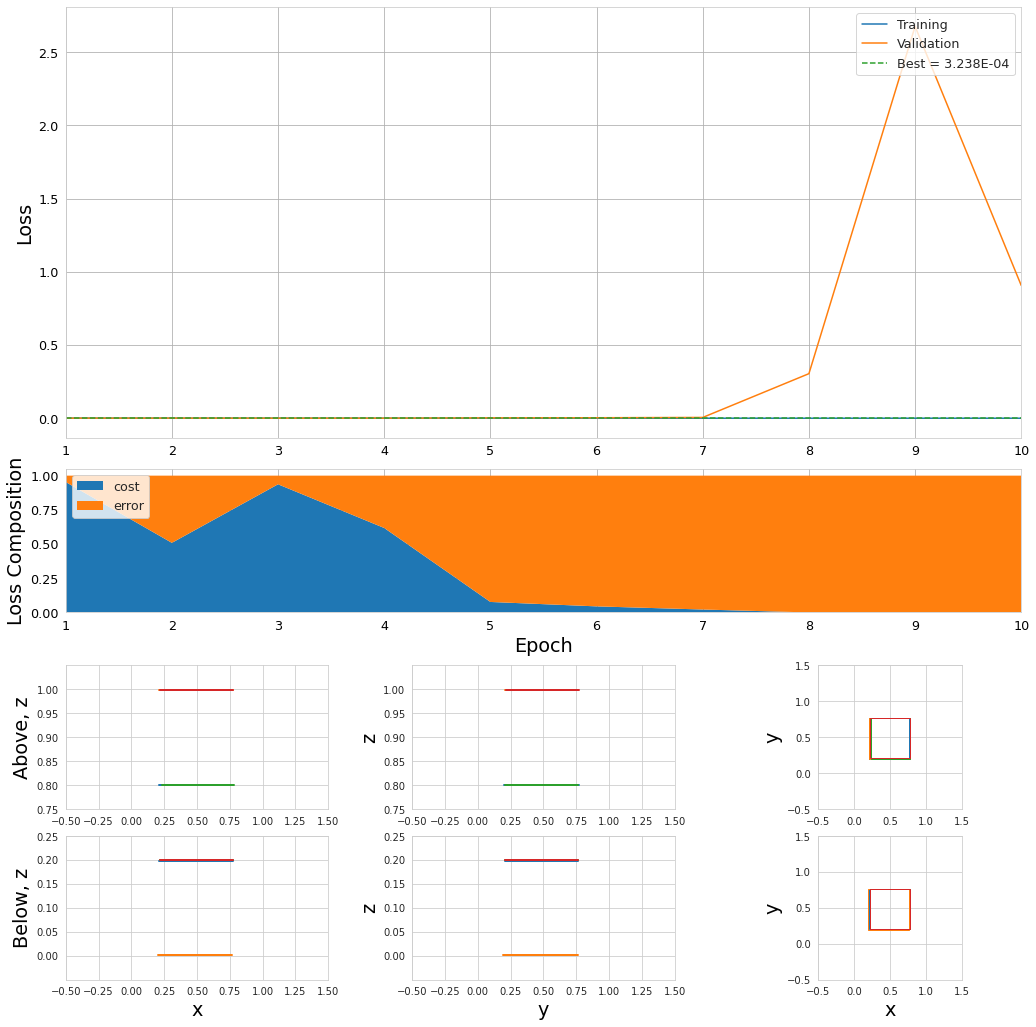

Automatically setting cost coefficient to 1.1826399713754654e-05
cost 8.0, cost coef 1.1826399713754654e-05, budget coef 46.0. error loss 1.1826399713754654e-05, cost loss 0.0005440143868327141
cost 6.874896049499512, cost coef 1.1826399713754654e-05, budget coef 38.96809768676758. error loss 2.249689532618504e-05, cost loss 0.0004608522867783904


/Users/giles/cernbox/mode_muon_tomography/tomopt/optimisation/callbacks/monitors.py:207: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim(1 / self.n_trn_batches, x[-1])


cost 6.874896049499512, cost coef 1.1826399713754654e-05, budget coef 38.96809768676758. error loss 1.0913304322457407e-05, cost loss 0.0004608522867783904
cost 5.912609100341797, cost coef 1.1735090083675459e-05, budget coef 32.95380401611328. error loss 0.00037323147989809513, cost loss 0.000386715866625309
cost 5.912609100341797, cost coef 1.1735090083675459e-05, budget coef 32.95380401611328. error loss 3.635898110587732e-06, cost loss 0.000386715866625309
cost 5.08258581161499, cost coef 1.0925170499831438e-05, budget coef 27.766159057617188. error loss 2.0496883735177107e-05, cost loss 0.0003033500106539577
cost 5.08258581161499, cost coef 1.0925170499831438e-05, budget coef 27.766159057617188. error loss 8.433285074715968e-07, cost loss 0.0003033500106539577
cost 4.41339635848999, cost coef 9.91698652796913e-06, budget coef 23.58372688293457. error loss 0.0001449257106287405, cost loss 0.00023387950204778463
cost 4.41339635848999, cost coef 9.91698652796913e-06, budget coef 23.5

<Figure size 1024x1024 with 0 Axes>

In [78]:
_ = wrapper.fit(n_epochs=10,
                passive_bs=1,
                n_mu_per_volume=1000,
                mu_bs=100,
                trn_passives=passives,
                val_passives=passives,
                cbs=[CostCoefAdapter(0.1), PanelMetricLogger()])

In [17]:
for p in volume.parameters(): print(p)

Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.9993], requires_grad=True)
Parameter containing:
tensor([0.0500, 0.0500], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.9500], requires_grad=True)
Parameter containing:
tensor([0.0500, 0.0500], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.8978], requires_grad=True)
Parameter containing:
tensor([0.0500, 0.0500], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.8379], requires_grad=True)
Parameter containing:
tensor([0.0500, 0.0500], requires_grad=True)
Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True)
Parameter containing:
tensor([0.1990], requires_grad=True)
Parameter containing:
tensor([0.0500, 0.0500], requires_grad=True)
Parameter containing:
tensor([0.500